In [4]:
import pandas as pd 
from pool import AMMPool, AMMPoolHistory, CPMM, AMMWithBaulking
import matplotlib as mpl
from matplotlib import pyplot as plt
import sysconfig

In [5]:
print(sysconfig.get_python_version())

3.10


**Define Pools to study and initialize**

In [6]:
# Define token1=USDC and token0=WETH
token1 = '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'
token0 = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

**Get Uni trades stream**  

In [7]:
from datastreams.datastream import Streamer

query_size = 10000

# instantiate Streamer object. 
# Note - unlike the cow queries, univ3 does not require multiple streamer instantations because the swaps field path is reset each iteration. 
# If the Cow queries were updated to use the same method, we could use the same streamer object for all queries.
univ3_ds = Streamer('https://api.thegraph.com/subgraphs/name/messari/uniswap-v3-ethereum')

# get a query field path from the query dictionary which is automatically populated in the Streamer object
uni_swaps_fp = univ3_ds.queryDict.get('swaps')

# define query path and parameters 
uni_swaps_qp = uni_swaps_fp(
        first=query_size, 
        orderBy='timestamp',
        orderDirection='asc',
        where = {'timestamp_gt':1643673600, 'pool': '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'} 
        )

# run query
uni_swaps_df = univ3_ds.runQuery(uni_swaps_qp)

FIELD - swaps


In [8]:
# Find the first and last value in the timestamp column
first_timestamp_uni = uni_swaps_df['swaps_timestamp'].min()
last_timestamp_uni = uni_swaps_df['swaps_timestamp'].max()
print(first_timestamp_uni, last_timestamp_uni)

1643673723 1645732238


**get chainlink pricing to value pools**

In [9]:
# load streamer class
chain_ds = Streamer('https://api.thegraph.com/subgraphs/name/openpredict/chainlink-prices-subgraph')
chain_price_feed = "ETH/USD"

In [10]:
# get a query field path from the query dictionary which is automatically populated in the Streamer object
chain_fp = chain_ds.queryDict.get('prices')

# add parameters to the settlements_qp.
chain_qp = chain_fp(
    first= 10000,
    orderBy='timestamp',
    orderDirection='asc',
    where = {'timestamp_gt':1643673600, 'assetPair': chain_price_feed}
    )

# run query
chain_df = chain_ds.runQuery(chain_qp)

FIELD - prices


In [11]:
# drop prices_id, endpoint. 
chain_df = chain_df.drop(['prices_id', 'endpoint'], axis=1)
# divide prices_price by 1e8 to get the price in USD
chain_df['prices_price'] = chain_df['prices_price'] / 10 ** 8

In [12]:
# Find the first and last value in the timestamp column
first_timestamp = chain_df['prices_timestamp'].min()
last_timestamp = chain_df['prices_timestamp'].max()
print(first_timestamp, last_timestamp)

1643676926 1657307781


In [13]:
timestamps = pd.DataFrame({'prices_timestamp': range(first_timestamp, last_timestamp + 1)})

In [14]:
# left merge chain_df with empty timestamps_df
chain_df = pd.merge(timestamps, chain_df, on='prices_timestamp', how='left')

In [15]:
# Forward-fill missing values
chain_df.fillna(method='ffill', inplace=True)
# reset index
price_s = chain_df.set_index("prices_timestamp")["prices_price"] / 1000 # small chainlink prices?

**get initialization price**

In [16]:
# chainlink at first_timestamp of uni trades:
initialization_df = chain_df[chain_df["prices_timestamp"] == first_timestamp]
initilizatioin_price = initialization_df.iloc[0,2]

2691.31586673

In [40]:
# initialize 100m USDC
USDC_reserves_USD = 100000000

In [41]:
token1_start = USDC_reserves_USD
print(f"Token 1 (microUSDC) initializer:\t{token1_start}")
token0_start = int(USDC_reserves_USD/initilizatioin_price)
print(f"Token 0 (nanoWETH) initializer: \t{token0_start}")

Token 1 (microUSDC) initializer:	100000000
Token 0 (nanoWETH) initializer: 	37156


**1.Simple AMM. SWAP ALL** 

In [42]:
# Create an instance of AMMPoolHistory 
feedlot1 = AMMPoolHistory(token0_start, token1_start)

In [43]:
print(f'price initialized by chainilnk: {initilizatioin_price}')

price initialized by chainilnk: 2691.31586673


In [45]:
# sanity check: should be USDC/WETH price
print(f'feedlot initialized price: {feedlot1.reserves[1] / feedlot1.reserves[0]}')

feedlot initialized price: 2691.355366562601


In [46]:
# Instantiate the CPMM object with the AMMPool object
cpmm = CPMM(pool=feedlot1)
cpmm_SI_flow = AMMWithBaulking(cpmm, price_s)

In [47]:
print(cpmm_SI_flow.amm.pool.reserves[1] / cpmm_SI_flow.amm.pool.reserves[0])

2691.355366562601


In [ ]:
# if swaps_tokenIn_id is 0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2, then divide swaps_amountIn by 1e18 to get amount in WETH
# if swaps_tokenIn_id is 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48, then divide swaps_amountIn by 1e6 to get amount in USDC

# if uni_swaps_df['swaps_tokenIn_id'] == token0, then divide swaps_amountIn by 1e18 to get amount in WETH
# if uni_swaps_df['swaps_tokenIn_id'] == token1, then divide swaps_amountIn by 1e6 to get amount in USDC

In [56]:
# Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    if row['swaps_timestamp'] < 1643676926: continue # wait until we have chainlink prices
    # Determine if the swap is a buy or a sell
    is_buy = row['swaps_tokenIn_id'] == token0 and row['swaps_tokenOut_id'] == token1
    amt = row['swaps_amountInUSD']
    
    # Extract the amountIn, amountOut, and timestamp
    if is_buy:
        token = 0
    else:
        token = 1 
     
    # Run the swap function on the AMM pool
    amt0, amt1 = cpmm_SI_flow.maybe_market_order_sell(amt,token,row['swaps_timestamp'])
    # print(f"Traded {amt0} for {amt1}\tat time {row['swaps_timestamp']}.")
    #print(f"Pool reserves: ({feedlot1.reserves[0], feedlot1.reserves[1]})")

ZeroDivisionError: float division by zero

In [ ]:
results1_df = pd.DataFrame(feedlot1.history)

In [ ]:
prices=(results1_df["reserve1"] / results1_df["reserve0"])

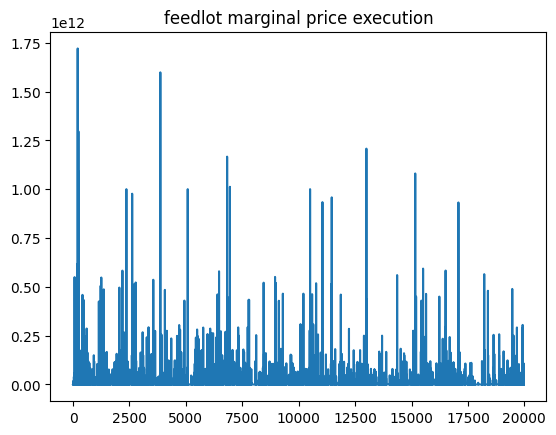

In [57]:
prices.plot()
plt.title('feedlot marginal price execution')
plt.show();

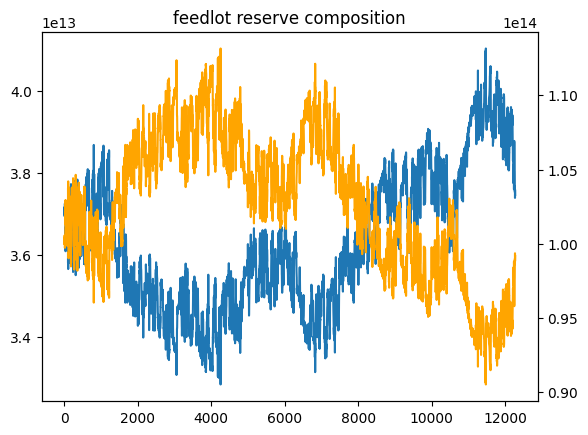

In [33]:
ax0 =results1_df["reserve0"].plot()
ax1 = ax0.twinx()
ax1 =results1_df["reserve1"].plot(color="orange")
plt.title('feedlot reserve composition')
plt.show();

In [34]:
# merge feedlot history with chainlink price
merged1_df = pd.merge(results1_df, chain_df, left_on='ts', right_on='prices_timestamp')
merged1_df.rename(columns={'prices_price': 'chainlink_price'}, inplace=True)
# calculate tvl value of the pool with chainlink prices
merged1_df['value'] = (merged1_df['reserve1']*merged1_df['chainlink_price']/(10**18)) + merged1_df['reserve0']/(10**18)

In [35]:
# check how many null values there are
merged1_df.isna().sum()

ts                     0
reserve0               0
reserve1               0
prices_timestamp       0
prices_assetPair_id    0
chainlink_price        0
value                  0
dtype: int64

In [38]:
merged1_df

,ts,reserve0,reserve1,prices_timestamp,prices_assetPair_id,chainlink_price,value
0,1643677266,3.714731e+13,100023400000000,1643677266,ETH/USD,2691.315867,0.269232
1,1643677640,3.705478e+13,100273155238047,1643677640,ETH/USD,2691.315867,0.269904
2,1643677829,3.700865e+13,100398155238047,1643677829,ETH/USD,2691.315867,0.270240
3,1643677886,3.701363e+13,100384642310735,1643677886,ETH/USD,2691.315867,0.270204
4,1643678003,3.702097e+13,100364728573895,1643678003,ETH/USD,2691.315867,0.270150
...,...,...,...,...,...,...,...
12264,1645731605,3.763817e+13,98718924061503,1645731605,ETH/USD,2554.168141,0.252182
12265,1645731622,3.759533e+13,98831424061503,1645731622,ETH/USD,2554.168141,0.252470
12266,1645732198,3.755734e+13,98931390810383,1645732198,ETH/USD,2567.478087,0.254042
12267,1645732198,3.754090e+13,98974708863489,1645732198,ETH/USD,2567.478087,0.254153


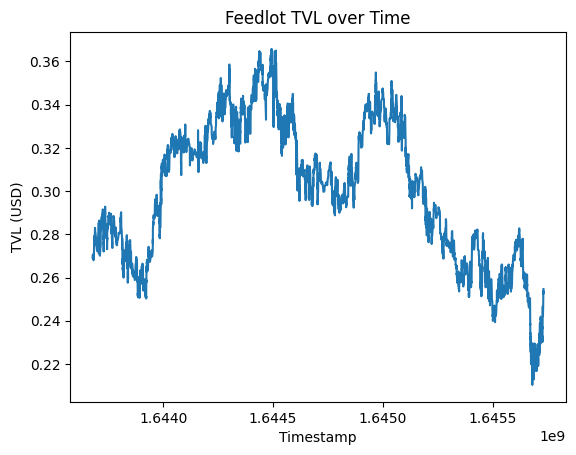

In [37]:
fig, ax = plt.subplots()
ax.plot(merged1_df['ts'], merged1_df['value'])
ax.set_title('Feedlot TVL over Time')
ax.set_xlabel('Timestamp')
ax.set_ylabel('TVL (USD)')
plt.show();
#fig.savefig('value_vs_timestamp.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()
ax.plot(merged1_df['ts'], merged1_df['reserve0'])
ax.set_title('CPMM reserves0')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()
ax.plot(merged1_df['ts'], merged1_df['reserve1'])
ax.set_title('CPMM reserves1')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)

In [ ]:
import matplotlib.pyplot as plt

# Assume that df is your dataframe with three columns: time, col1, and col2

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot col1 on the first y-axis
ax.plot(merged1_df["ts"], merged1_df["reserve0"], label="reserve0")

# Create a second y-axis on the right-hand side
ax2 = ax.twinx()

# Plot col2 on the second y-axis
ax2.plot(merged1_df["ts"], merged1_df["reserve1"], color="orange", label="col2")

# Add legends and axis labels
ax.set_xlabel("Timestamp")
ax.set_ylabel("reserve0")
ax2.set_ylabel("reserve1")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()


**OraclePool AMM**

**get cow trades for oracle pricing** 

In [ ]:
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

# get COW trades 

trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades
trades_qp = trades_fp(
    first=10000,
    orderBy='timestamp',
    orderDirection='asc',
    where={'timestamp_gt':1643673600, 'sellToken':'0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48',
           'buyToken':'0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

In [ ]:
trades_df.shape

In [ ]:
trades_df.head(5)

In [ ]:
# Set query size large enough to retrieve all tokens in the graph
query_size = 10000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size,
)

# run query
token_df = cow_ds.runQuery(token_qp)


In [ ]:
token_df.shape

In [ ]:
# Merge1 on sell token address.  x = sell token 

merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

merged_df.shape

In [ ]:
# Merge2 on buy token address.  y = buy token 
cow_df = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

cow_df.shape

In [ ]:
cow_df.dtypes

In [ ]:
# calculate buy and sell amounts from the correct decimal 
cow_df['sell_amount'] = cow_df.apply(lambda x: x['trades_sellAmount'] / (10**x['tokens_decimals_x']), axis=1)
cow_df['buy_amount'] = cow_df.apply(lambda x: x['trades_buyAmount'] / (10**x['tokens_decimals_y']), axis=1)

In [ ]:
# calculate COW price defined sell amount / buy amount
cow_df['cow_price'] = cow_df['sell_amount'] / cow_df['buy_amount']

In [ ]:
cow_df

In [ ]:
# Find the first and last value in the timestamp column
first_timestamp_cow = chain_df['prices_timestamp'].min()
last_timestamp_cow = chain_df['prices_timestamp'].max()

In [ ]:
first_timestamp_cow

In [ ]:
last_timestamp_cow

In [ ]:
oracle_dict = [{"ts": row["trades_timestamp"], "p": row["cow_price"]} for _, row in cow_df.iterrows()]

In [ ]:
oracle_dict

**Oracle pool simulation**

In [ ]:
from pool import CPMM, AMMPool, SwapRejectedError, OraclePool

In [ ]:
# Create an instance of AMMPoolHistory 
feedlot2 = AMMPoolHistory(token0_start, token1_start)

In [ ]:
feedlot3 = OraclePool(feedlot2, oracle_dict)

In [ ]:
 # Iterate through the rows of the dataframe
for index, row in uni_swaps_df.iterrows():
    # Determine if the swap is a buy or a sell
    token_in = row['swaps_tokenIn_id']
    token_out = row['swaps_tokenOut_id']
    is_buy = token_in == token0 and token_out == token1
    amt = row['swaps_amountIn']
    
    # Extract the amountIn, amountOut, and timestamp
    if is_buy:
        token = 0
    else:
        token = 1 
    ts = row['swaps_timestamp']
    
    print('token', token)
    print('amt', amt)
    print('amt',amt/10**18)
    print('token_in', token_in)
    print('ts', ts)
    
    # Run the swap function on the AMM pool
    feedlot3.market_order_sell(amt,token,ts)

In [ ]:
results2 = pd.DataFrame(feedlot2.history)

In [ ]:
results2.shape

In [ ]:
results2.head(5)

In [ ]:
merged2_df = pd.merge(results2, chain_df, left_on='ts', right_on='prices_timestamp')
merged2_df.rename(columns={'prices_price': 'chainlink_price'}, inplace=True)

In [ ]:
merged2_df['value'] = merged2_df['reserve1']*merged2_df['chainlink_price']/10**18 + merged2_df['reserve0']/10**18

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(merged2_df['ts'], merged2_df['value'])
ax.set_title('Value vs. Timestamp')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Value')
#fig.savefig('value_vs_timestamp.png', dpi=300)

In [ ]:
# Assume that df is your dataframe with three columns: time, col1, and col2

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot col1 on the first y-axis
ax.plot(merged2_df["ts"], merged2_df["reserve0"], label="reserve0")

# Create a second y-axis on the right-hand side
ax2 = ax.twinx()

# Plot col2 on the second y-axis
ax2.plot(merged2_df["ts"], merged2_df["reserve1"], color="orange", label="reserves1")

# Add legends and axis labels
ax.set_xlabel("Timestamp")
ax.set_ylabel("reserve0")
ax2.set_ylabel("reserve1")
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()